In [68]:
%pip install nbformat
%pip install imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [69]:
import nbformat

nb = nbformat.read("ml_project.ipynb", as_version=4)
# Normalize the notebook to add missing id fields and other updates
nbformat.validator.validate(nb)

# Write the normalized notebook back to a file
nbformat.write(nb, "ml_project_normalized.ipynb")

In [70]:
# run ml project to get access to cleaned data
%run ml_project_normalized.ipynb

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Unique primary colors:
 1. black
 2. non-black
dropped columns
cleaned intake time
cleaned intake condition
cleaned age and sex
Unique primary colors:
 1. black
 2. non-black
cleaned color
cleaned breed
dropped columns


/var/folders/yf/n0zzld6945vfyf6hj9_n1g4c0000gn/T/ipykernel_95083/1199118304.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dt_series = pd.to_datetime(df['intake_time'], errors='coerce')


cleaned intake time
cleaned intake condition
cleaned age and sex
Unique primary colors:
 1. black
 2. non-black
cleaned color
cleaned breed
Done running ml_project.ipynb.


In [71]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from imblearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_val_score, train_test_split
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from scipy.stats import randint, uniform
from sklearn.metrics import accuracy_score, balanced_accuracy_score

import numpy as np
import pandas as pd

def train_XG_classifier(X_train, y_train, X_test, rare_classes, cat_cols, custom_thresholds=None):
    """
    Trains an XGBoost model using hyperparameter tuning.
    Applies custom thresholding during prediction if specified and compares standard vs. custom accuracy.

    Parameters:
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series or np.array): Training target values.
        X_test (pd.DataFrame): Test features.
        rare_classes (list): List of integer-encoded classes to be oversampled. Was used for SMOTE.
        cat_cols (set or list): Categorical columns to one-hot encode.
        custom_thresholds (dict, optional): Dict of class_label -> threshold.
            e.g., {0: 0.7, 1: 0.5, 2: 0.5} for class 0 = supermajority.

    Returns:
        best_estimator: Trained pipeline.
        test_predictions: Custom-thresholded predictions.
        df_importances: Feature importances from XGBoost.
    """

    # Calculate sample weights to be used during training to better balance the data
    class_labels = np.unique(y_train)
    class_weights = compute_class_weight('balanced', classes=class_labels, y=y_train)
    class_weight_dict = dict(zip(class_labels, class_weights))
    sample_weights = np.array([class_weight_dict[y] for y in y_train])

    # Ensure categorical features are treated as such
    categorical_features = [col for col in X_train.columns if col in cat_cols]
    for col in categorical_features:
        X_train[col] = X_train[col].astype(str)
        X_test[col] = X_test[col].astype(str)

    # One hot encode categorical features, while allowing passthrough for numerical values.
    # Ignores categorical values that are not seen in the train set.
    preprocessor = ColumnTransformer(
        transformers=[
            ("onehot", OneHotEncoder(handle_unknown='ignore', sparse_output=True), categorical_features)
        ],
        remainder='passthrough'
    )

    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("xgb", XGBClassifier(eval_metric='logloss', verbosity=1))
    ])

    # Uniform and randint parameters allowed for more variation while training. When running
    # xg boost a large number of times, it gave a better chance of finding an outlier
    # Set of parameters that worked really well.
    param_distributions = {
        "xgb__max_depth": randint(2, 11),
        "xgb__learning_rate": uniform(0.01, 0.29),
        "xgb__n_estimators": randint(50, 501),
        "xgb__subsample": uniform(0.3, 0.7),
        "xgb__colsample_bytree": uniform(0.3, 0.7),
        "xgb__min_child_weight": randint(1, 8),
        "xgb__gamma": uniform(0, 1.0),
        "xgb__reg_alpha": uniform(0, 1.0),
        "xgb__reg_lambda": uniform(0.5, 2.5)
    }

    # Guarantees that representatives from each class label makes it into each fold
    stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    randomized_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_distributions,
        n_iter=50,
        cv=stratified_cv,
        scoring='balanced_accuracy',
        verbose=3,
        random_state=42,
    )

    print(f"\n[INFO] Starting training with {len(X_train)} samples and {len(y_train)} labels")
    randomized_search.fit(X_train, y_train, **{'xgb__sample_weight': sample_weights})
    print(f"[INFO] Training complete. Best model fitted on {len(X_train)} samples.\n")

    # Shows a sample of the training features for debugging one hot encoding
    best_preprocessor = randomized_search.best_estimator_.named_steps['preprocessor']
    encoded_X_train = best_preprocessor.transform(X_train)
    if hasattr(encoded_X_train, "toarray"):
        encoded_X_train = encoded_X_train.toarray()
    feature_names = best_preprocessor.get_feature_names_out()
    print("Sample of transformed training features:")
    print(pd.DataFrame(encoded_X_train, columns=feature_names).head())

    print('Best parameters:', randomized_search.best_params_)
    print('Best cross-validation accuracy:', randomized_search.best_score_)

    cv_scores = cross_val_score(
        randomized_search.best_estimator_,
        X_train,
        y_train,
        cv=stratified_cv,
        verbose=3,
        scoring='balanced_accuracy'
    )
    print('Generalization accuracy (via cross_val_score):', cv_scores.mean())

    # Predict with custom thresholds if provided
    xgb_model = randomized_search.best_estimator_.named_steps['xgb']
    class_names = xgb_model.classes_

    # Thresholds further assisted with class imbalance: in order to predict a label, it must at
    # least met the threshold provided. This was done to make Adoption predictions require
    # a higher level of confidence
    def apply_custom_thresholds(probabilities, class_names, thresholds_dict):
        thresholds = np.array([thresholds_dict.get(cls, 0.5) for cls in class_names])
        preds = []
        for row in probabilities:
            passed = row >= thresholds
            if not passed.any():
                pred = class_names[np.argmax(row)]
            else:
                pred = class_names[np.argmax(passed * row)]
            preds.append(pred)
        return np.array(preds)

    # get probabilistic distribution of each record for all labels to be used with thresholding
    proba_test = randomized_search.predict_proba(X_test)
    if custom_thresholds:
        print("[INFO] Applying custom threshold logic to test set")
        test_predictions = apply_custom_thresholds(proba_test, class_names, custom_thresholds)
    else: # use normal predictions w/o threshold
        test_predictions = randomized_search.predict(X_test)

    # Evaluate performance on training set (standard vs. custom)
    proba_train = randomized_search.predict_proba(X_train)
    if custom_thresholds:
        preds_custom_train = apply_custom_thresholds(proba_train, class_names, custom_thresholds)
        acc_standard = accuracy_score(y_train, randomized_search.predict(X_train))
        acc_custom = accuracy_score(y_train, preds_custom_train)
        bal_acc_standard = balanced_accuracy_score(y_train, randomized_search.predict(X_train))
        bal_acc_custom = balanced_accuracy_score(y_train, preds_custom_train)

        print(f"\nAccuracy Comparison on Training Set:")
        print(f"Standard Accuracy: {acc_standard:.4f}")
        print(f"Custom Threshold Accuracy: {acc_custom:.4f}")
        print(f"Standard Balanced Accuracy: {bal_acc_standard:.4f}")
        print(f"Custom Threshold Balanced Accuracy: {bal_acc_custom:.4f}")

    # Feature importances
    importances = xgb_model.feature_importances_
    df_importances = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    })

    return randomized_search.best_estimator_, test_predictions, df_importances


In [72]:
# Legacy code from trying downsampling.
'''
# from sklearn.utils import resample
# df_train_downsample = resample(df_train, replace=True, n_samples=10000, random_state=42)
# print(df_train_downsample.shape)
'''

'\n# from sklearn.utils import resample\n# df_train_downsample = resample(df_train, replace=True, n_samples=10000, random_state=42)\n# print(df_train_downsample.shape)\n'

In [73]:
# trying to see if xgboost would work better if we split dog and cat near the deadline.
# did not have enough time to see if it worked well or not

# df_dog = df_train[df_train['animal_type'] == 'Dog']
# df_dog = df_dog[~df_dog['breed'].str.contains('Unknown')]
# df_dog = df_dog[~df_dog['breed'].str.contains('Rare')]

# df_dog['kid-friendly'] = df_dog['kid-friendly'].astype(int)
# df_dog['easy_to_groom'] = df_dog['easy_to_groom'].astype(int)
# df_dog['general_health'] = df_dog['general_health'].astype(int)
# df_dog['energy_level'] = df_dog['energy_level'].astype(int)
# df_dog['exercise_needs'] = df_dog['exercise_needs'].astype(int)
# df_dog['potential_for_playfulness'] = df_dog['potential_for_playfulness'].astype(int)

# df_dog['potential_for_playfulness'].value_counts()

In [74]:
X_train = df_train.copy()
X_train = bucket_seasons(X_train)
X_train = bucket_days(X_train)
X_train = X_train.drop(columns=['intake_month', 'intake_hour'])
X_train.head()

,intake_type,intake_condition,animal_type,sex_upon_intake,age_upon_intake,breed,intake_year,primary_color,is_mix,size,outcome_type,season,time_of_day
0,Stray,Normal / Behavior,Dog,Spayed Female,96.0,2,2015,non-black,0,3,Return to Owner,Summer,Afternoon
1,Stray,Normal / Behavior,Dog,Intact Male,11.0,7,2016,non-black,1,2,Return to Owner,Spring,Evening
2,Public Assist,Normal / Behavior,Cat,Neutered Male,24.0,Common,2022,non-black,0,2,Transfer,Spring,Night
3,Owner Surrender,Normal / Behavior,Dog,Neutered Male,24.0,2,2017,non-black,1,4,Return to Owner,Winter,Afternoon
4,Public Assist,Normal / Behavior,Dog,Neutered Male,72.0,3,2019,black,1,5,Return to Owner,Spring,Morning


In [75]:
# Test feature engineering / cleaning


X_test = df_test.copy()
X_test = bucket_seasons(X_test)
X_test = bucket_days(X_test)
X_test = X_test.drop(columns=['intake_month', 'intake_hour'])
X_test.head()

,intake_type,intake_condition,animal_type,sex_upon_intake,age_upon_intake,breed,intake_year,primary_color,is_mix,size,season,time_of_day
0,Stray,Normal / Behavior,Dog,Neutered Male,24.0,7,2019,non-black,1,2,Winter,Afternoon
1,Stray,Sick,Cat,Intact Female,1.0,Common,2013,non-black,1,2,Fall,Morning
2,Stray,Normal / Behavior,Dog,Neutered Male,48.0,3,2014,non-black,1,4,Summer,Morning
3,Stray,Normal / Behavior,Dog,Intact Female,5.0,4,2015,non-black,0,3,Summer,Evening
4,Stray,Injured,Cat,Intact Female,24.0,Common,2017,black,1,2,Winter,Morning


In [ ]:
# Encoding class labels as numbers to play nice with the classifier (it complained when it was just a string)
le = LabelEncoder()
y_train = X_train['outcome_type']
X_train = X_train.drop(columns=['outcome_type'])
y_train = le.fit_transform(y_train)
print('Encoding mapping:', le.classes_)

# Identify rare classes that need oversampling
rare_classes = [
    label for label, count in pd.Series(y_train).value_counts().items()
    if count < 0.05 * len(y_train)
]

print("Rare classes:")
for cls in rare_classes:
    print(f"  {cls}: {le.classes_[cls]}")

# Define column groups (this example will one-hot encode all columns, so cat_cols and num_cols are not used in the transformer).
cat_cols = {'intake_type', 'intake_condition', 'animal_type', 'sex_upon_intake', 'breed', 'intake_month', 'intake_hour', 'intake_year', 'primary_color', 'season', 'time_of_day', 'size'}
categorical_features = [col for col in X_train.columns if col in cat_cols]
'''
'''
# Train the classifier with the refactored pipeline.

custom_thresholds = {
    0: 0.8, # Adopted, higher than others to predict on it less
    1: 0.5, # Died
    2: 0.5, # Euthanasia
    3: 0.5, # Return to Owner
    4: 0.5  # Transfer
}
best_model, test_predictions, df_importances = train_XG_classifier(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    rare_classes=rare_classes,
    cat_cols=categorical_features,
    custom_thresholds=custom_thresholds
)

# Convert predictions back to original labels.
predictions = le.inverse_transform(test_predictions)

classification_report_with_accuracy_score(y_test, predictions)
# Save predictions; assumes save_predictions is defined elsewhere.
save_predictions(predictions, 'xg_boost')

Encoding mapping: ['Adoption' 'Died' 'Euthanasia' 'Return to Owner' 'Transfer']
Rare classes:
  2: Euthanasia
  1: Died

[INFO] Starting training with 111155 samples and 111155 labels
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END xgb__colsample_bytree=0.5621780831931538, xgb__gamma=0.9507143064099162, xgb__learning_rate=0.22227824312530747, xgb__max_depth=6, xgb__min_child_weight=7, xgb__n_estimators=171, xgb__reg_alpha=0.15599452033620265, xgb__reg_lambda=0.6452090304204987, xgb__subsample=0.9063233020424546;, score=0.535 total time=   2.5s
[CV 2/5] END xgb__colsample_bytree=0.5621780831931538, xgb__gamma=0.9507143064099162, xgb__learning_rate=0.22227824312530747, xgb__max_depth=6, xgb__min_child_weight=7, xgb__n_estimators=171, xgb__reg_alpha=0.15599452033620265, xgb__reg_lambda=0.6452090304204987, xgb__subsample=0.9063233020424546;, score=0.518 total time=   2.5s
[CV 3/5] END xgb__colsample_bytree=0.5621780831931538, xgb__gamma=0.9507143064099162, xgb__l

KeyboardInterrupt: 

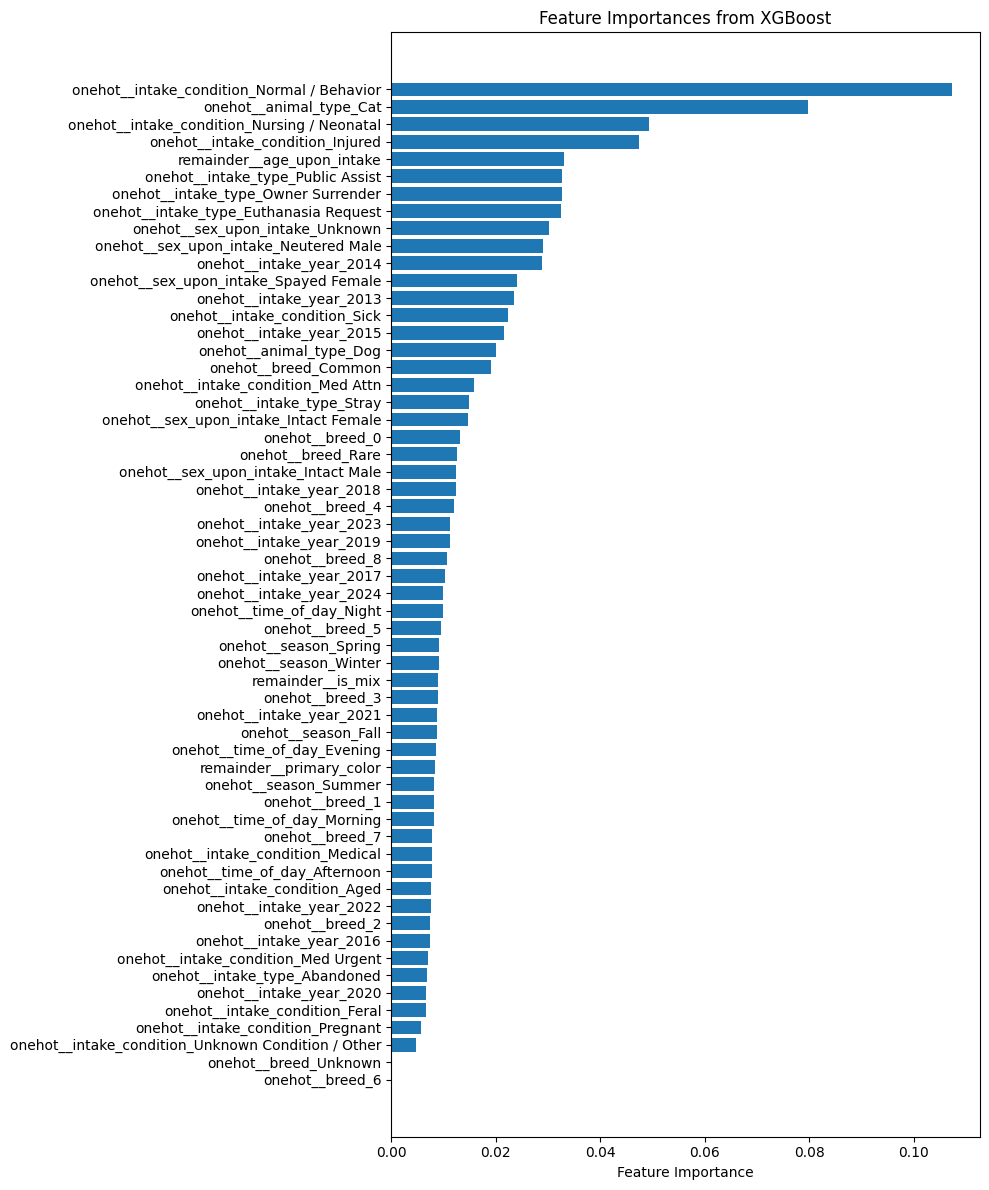

In [ ]:
import matplotlib.pyplot as plt

# Displays the feature importance scores. We used this information to see how our feature engineering was performing
# And if we should drop some features from the dataset.
df_plot = df_importances.sort_values(by='importance', ascending=True)

plt.figure(figsize=(10, 12))
plt.barh(df_plot['feature'], df_plot['importance'])
plt.xlabel('Feature Importance')
plt.title('Feature Importances from XGBoost')
plt.tight_layout()
plt.show()